In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Resetar contador se houver melhoria
        else:
            self.counter += 1  # Aumentar contador se não houver melhora
            if self.counter >= self.patience:
                print("Early stopping ativado!")
                return True
        return False

O CIFAR-10 contém 60.000 imagens (32x32 pixels) em 10 classes

In [ ]:
# Normalização para se ajustar aos valores do ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # A ResNet18 espera imagens 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carregar o dataset
batch_size = 32  # Número de imagens processadas por vez

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes do CIFAR-10
classes = ('avião', 'automóvel', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão')

Files already downloaded and verified
Files already downloaded and verified


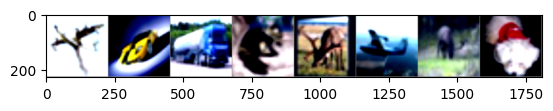

avião automóvel caminhão gato cervo avião cervo cachorro


In [ ]:
# Função para exibir imagens
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obter algumas imagens do dataset de treino
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Mostrar as imagens
imshow(torchvision.utils.make_grid(images[:8]))  # Mostrar 8 imagens
print(' '.join(classes[labels[j]] for j in range(8)))  # Mostrar classes

In [ ]:
# Carregar o modelo pré-treinado
model = models.resnet18(pretrained=True)

# Congelar todas as camadas (exceto a última)
for param in model.parameters():
    param.requires_grad = False  # Não atualizar pesos pré-treinados

# Modificar a última camada para 10 classes do CIFAR-10
num_ftrs = model.fc.in_features  # Número de entradas da última camada
model.fc = nn.Linear(num_ftrs, 10)  # Nova camada totalmente conectada

# Enviar para GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Contar o número de parâmetros
total_params = sum(p.numel() for p in model.parameters())  # Todos os parâmetros
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # Apenas os treináveis

# Imprimir resultados
print(f"Número total de parâmetros: {total_params:,}")
print(f"Número de parâmetros treináveis: {trainable_params:,}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Número total de parâmetros: 11,181,642
Número de parâmetros treináveis: 5,130


In [ ]:
criterion = nn.CrossEntropyLoss()  # Função de perda para classificação
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Apenas última camada

In [ ]:
num_epochs = 30  # Número máximo de épocas
early_stopping = EarlyStopping(patience=5, min_delta=0.001)  # Criar EarlyStopping

# Listas para armazenar a evolução das métricas
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()  # Modo treinamento
    running_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calcular loss e acurácia do treino
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validação
    model.eval()  # Modo avaliação
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calcular loss e acurácia da validação
    val_loss /= len(testloader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Época {epoch+1}/{num_epochs}, Perda: {train_loss:.4f}, Val_Loss: {val_loss:.4f}, Acc: {train_acc:.2f}%, Val_Acc: {val_acc:.2f}%")

    if early_stopping(val_loss):  # Verificar EarlyStopping
        break

print("Treinamento finalizado!")

Época 1/30, Perda: 0.8013, Val_Loss: 0.6200, Acc: 73.46%, Val_Acc: 78.57%
Época 2/30, Perda: 0.6400, Val_Loss: 0.5847, Acc: 77.83%, Val_Acc: 79.89%
Época 3/30, Perda: 0.6219, Val_Loss: 0.5884, Acc: 78.63%, Val_Acc: 79.97%
Época 4/30, Perda: 0.6108, Val_Loss: 0.5888, Acc: 78.93%, Val_Acc: 80.02%
Época 5/30, Perda: 0.6007, Val_Loss: 0.5737, Acc: 79.39%, Val_Acc: 80.50%
Época 6/30, Perda: 0.5924, Val_Loss: 0.5926, Acc: 79.46%, Val_Acc: 79.81%
Época 7/30, Perda: 0.5934, Val_Loss: 0.6014, Acc: 79.49%, Val_Acc: 79.54%
Época 8/30, Perda: 0.5923, Val_Loss: 0.5656, Acc: 79.57%, Val_Acc: 80.64%
Época 9/30, Perda: 0.5877, Val_Loss: 0.5770, Acc: 79.74%, Val_Acc: 80.19%
Época 10/30, Perda: 0.5859, Val_Loss: 0.6034, Acc: 79.93%, Val_Acc: 79.90%
Época 11/30, Perda: 0.5833, Val_Loss: 0.5635, Acc: 79.90%, Val_Acc: 81.03%
Época 12/30, Perda: 0.5848, Val_Loss: 0.5774, Acc: 79.80%, Val_Acc: 80.51%
Época 13/30, Perda: 0.5789, Val_Loss: 0.5707, Acc: 80.06%, Val_Acc: 80.71%
Época 14/30, Perda: 0.5772, Val_Lo

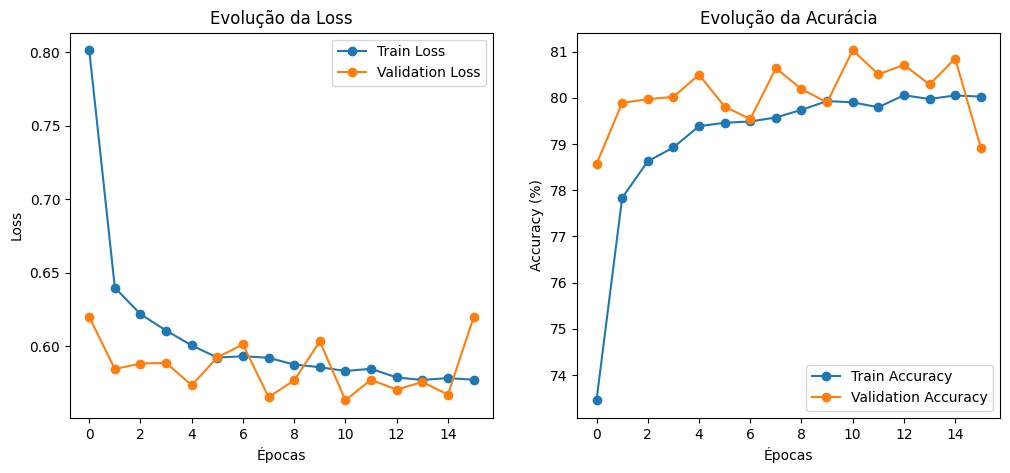

In [ ]:
plt.figure(figsize=(12, 5))

# Loss (Perda) durante o treino
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Evolução da Loss')
plt.legend()

# Accuracy (Acurácia) durante o treino
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Épocas')
plt.ylabel('Accuracy (%)')
plt.title('Evolução da Acurácia')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Avaliar métricas
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Pegamos a classe com maior probabilidade
        true_labels.extend(labels.cpu().numpy())  # Salvar rótulos reais
        pred_labels.extend(predicted.cpu().numpy())  # Salvar previsões

# Calcular métricas
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Precision: 0.8074
Recall: 0.7892
F1-score: 0.7865


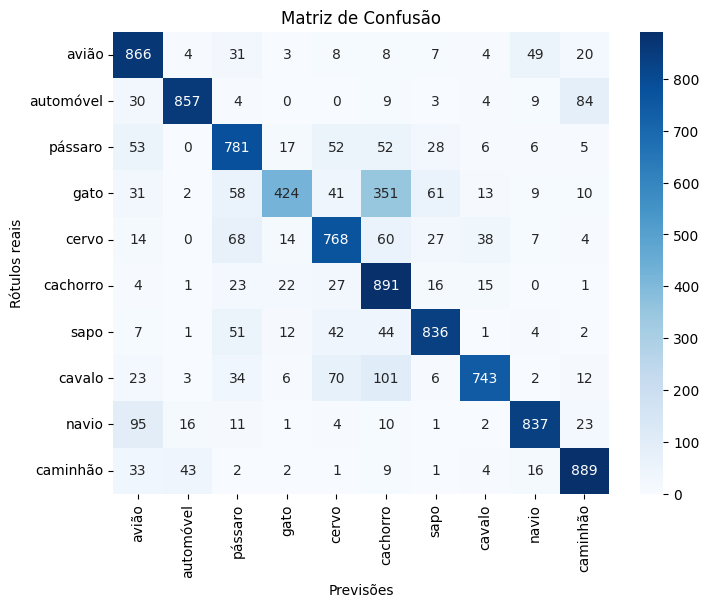

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Criar matriz de confusão
cm = confusion_matrix(true_labels, pred_labels)

# Plotar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Previsões')
plt.ylabel('Rótulos reais')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
import torch.nn as nn
import torchvision.models as models

# Carregar o modelo pré-treinado
model = models.resnet18(pretrained=True)

# Congelar todas as camadas convolucionais (exceto a última)
for param in model.parameters():
    param.requires_grad = False  # Não atualizar pesos pré-treinados

# Modificar a estrutura do modelo para remover o Average Pooling
class ModifiedResNet18(nn.Module):
    def __init__(self, original_model, num_classes=10):
        super(ModifiedResNet18, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])  # Remove avgpool e fc
        self.flatten = nn.Flatten()  # Adiciona Flatten manualmente
        self.fc = nn.Linear(512 * 7 * 7, num_classes)  # 512 canais * 7x7 da última convolução

    def forward(self, x):
        x = self.features(x)  # Extrai features da ResNet18 sem avgpool
        x = self.flatten(x)  # Aplica Flatten
        x = self.fc(x)  # Camada totalmente conectada
        return x

# Criar o modelo modificado
model = ModifiedResNet18(model, num_classes=10)

# Enviar para GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())  # Todos os parâmetros
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # Apenas os treináveis

# Imprimir resultados
print(f"Número total de parâmetros: {total_params:,}")
print(f"Número de parâmetros treináveis: {trainable_params:,}")

Número total de parâmetros: 11,427,402
Número de parâmetros treináveis: 250,890


In [ ]:
criterion = nn.CrossEntropyLoss()  # Função de perda para classificação
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Apenas última camada

In [ ]:
num_epochs = 30  # Defina um número maior de épocas
early_stopping = EarlyStopping(patience=5, min_delta=0.001)  # Criar EarlyStopping

for epoch in range(num_epochs):
    model.train()  # Modo treinamento
    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validação
    model.eval()  # Modo avaliação
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(testloader)  # Média da perda de validação
    print(f"Época {epoch+1}/{num_epochs}, Perda: {running_loss/len(trainloader):.4f}, Val_Loss: {val_loss:.4f}")

    if early_stopping(val_loss):  # Verificar EarlyStopping
        break

print("Treinamento finalizado!")

Época 1/30, Perda: 3.7126, Val_Loss: 3.8271
Época 2/30, Perda: 3.5598, Val_Loss: 4.8985
Época 3/30, Perda: 3.2319, Val_Loss: 5.3055
Época 4/30, Perda: 3.1803, Val_Loss: 5.7631
Época 5/30, Perda: 2.8351, Val_Loss: 4.9446
Época 6/30, Perda: 2.6856, Val_Loss: 5.7641
Early stopping ativado!
Treinamento finalizado!


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Avaliar métricas
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Pegamos a classe com maior probabilidade
        true_labels.extend(labels.cpu().numpy())  # Salvar rótulos reais
        pred_labels.extend(predicted.cpu().numpy())  # Salvar previsões

# Calcular métricas
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Precision: 0.8122
Recall: 0.7955
F1-score: 0.7974


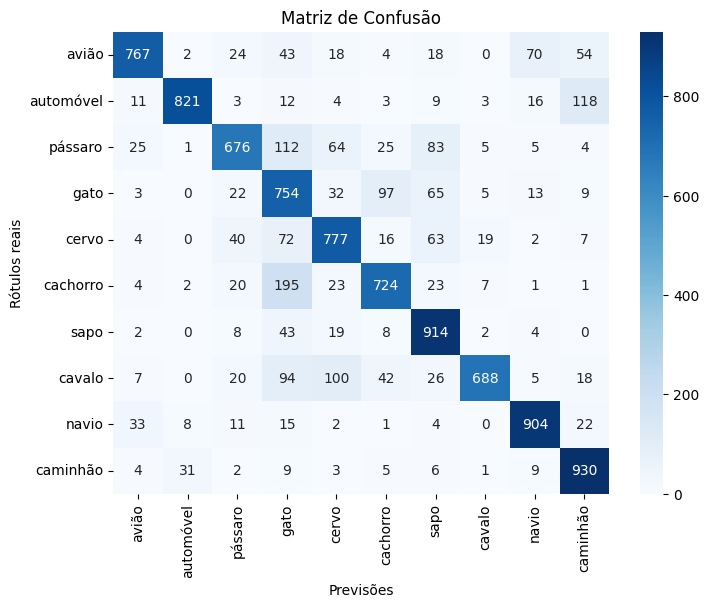

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Criar matriz de confusão
cm = confusion_matrix(true_labels, pred_labels)

# Plotar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Previsões')
plt.ylabel('Rótulos reais')
plt.title('Matriz de Confusão')
plt.show()

MobileNetV2 no CIFAR-10

In [ ]:
!pip install torch torchvision matplotlib seaborn

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# Normalização e aumento de dados
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # MobileNetV2 requer 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carregar CIFAR-10
batch_size = 32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes do CIFAR-10
classes = ('avião', 'automóvel', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão')

Files already downloaded and verified
Files already downloaded and verified


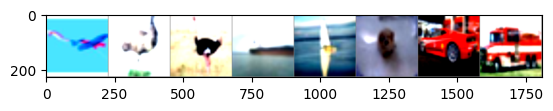

avião pássaro pássaro navio navio cachorro automóvel caminhão


In [ ]:
# Função para exibir imagens
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Exibir algumas imagens
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(classes[labels[j]] for j in range(8)))

In [ ]:
# Carregar MobileNetV2 pré-treinado
model = models.mobilenet_v2(pretrained=True)

# Congelar camadas convolucionais
for param in model.features.parameters():
    param.requires_grad = False

# Modificar a última camada para 10 classes (CIFAR-10)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)

# Enviar para GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())  # Todos os parâmetros
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # Apenas os treináveis

# Imprimir resultados
print(f"Número total de parâmetros: {total_params:,}")
print(f"Número de parâmetros treináveis: {trainable_params:,}")

Número total de parâmetros: 2,236,682
Número de parâmetros treináveis: 12,810


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)

# EarlyStopping manual
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping ativado!")
                return True
        return False

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

In [ ]:
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validação
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(testloader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Época {epoch+1}/{num_epochs}, Perda: {train_loss:.4f}, Val_Loss: {val_loss:.4f}, Acc: {train_acc:.2f}%, Val_Acc: {val_acc:.2f}%")

    if early_stopping(val_loss):
        break

print("Treinamento finalizado!")

Época 1/30, Perda: 0.8764, Val_Loss: 0.7120, Acc: 69.79%, Val_Acc: 75.28%
Época 2/30, Perda: 0.7615, Val_Loss: 0.6597, Acc: 73.51%, Val_Acc: 76.88%
Época 3/30, Perda: 0.7510, Val_Loss: 0.6498, Acc: 74.00%, Val_Acc: 77.22%
Época 4/30, Perda: 0.7509, Val_Loss: 0.6445, Acc: 73.99%, Val_Acc: 77.80%
Época 5/30, Perda: 0.7502, Val_Loss: 0.6380, Acc: 74.06%, Val_Acc: 77.68%
Época 6/30, Perda: 0.7501, Val_Loss: 0.6549, Acc: 74.11%, Val_Acc: 77.14%
Época 7/30, Perda: 0.7443, Val_Loss: 0.6450, Acc: 74.20%, Val_Acc: 77.50%
Época 8/30, Perda: 0.7493, Val_Loss: 0.6404, Acc: 74.05%, Val_Acc: 77.58%
Época 9/30, Perda: 0.7458, Val_Loss: 0.6274, Acc: 74.20%, Val_Acc: 78.14%
Época 10/30, Perda: 0.7479, Val_Loss: 0.6283, Acc: 74.16%, Val_Acc: 78.10%
Época 11/30, Perda: 0.7445, Val_Loss: 0.6434, Acc: 74.37%, Val_Acc: 77.86%
Época 12/30, Perda: 0.7465, Val_Loss: 0.6190, Acc: 74.27%, Val_Acc: 78.70%
Época 13/30, Perda: 0.7507, Val_Loss: 0.6263, Acc: 74.28%, Val_Acc: 78.25%
Época 14/30, Perda: 0.7383, Val_Lo

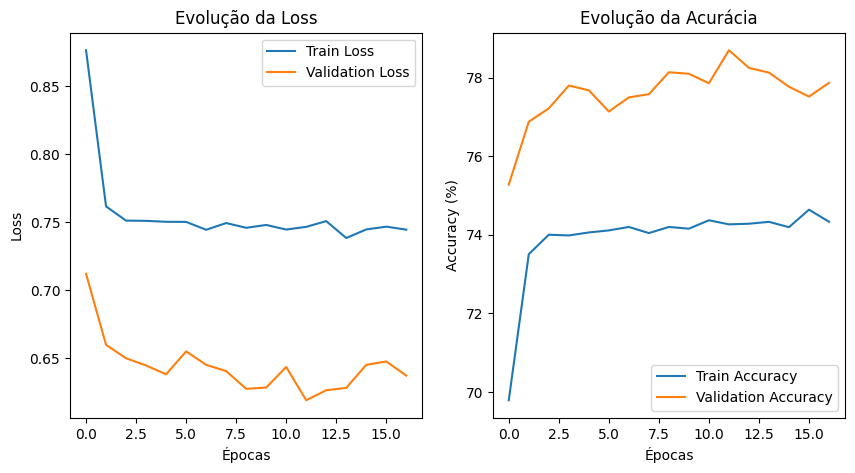

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Evolução da Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy (%)')
plt.title('Evolução da Acurácia')
plt.legend()

plt.show()

Precision: 0.7833
Recall: 0.7787
F1-score: 0.7780


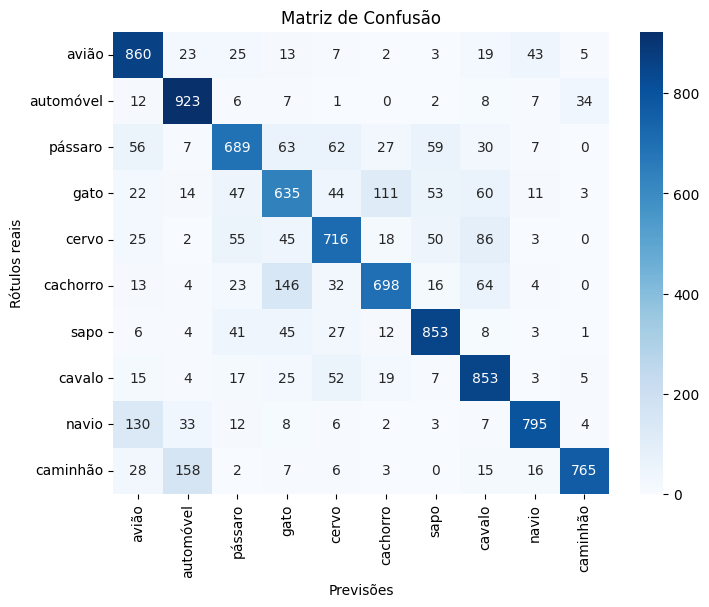

In [ ]:
true_labels, pred_labels = [], []

model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Métricas
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Matriz de Confusão
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Previsões')
plt.ylabel('Rótulos reais')
plt.title('Matriz de Confusão')
plt.show()